Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Epoch [1/10], Step [10/2881], Loss: 4.3914
Epoch [1/10], Step [20/2881], Loss: 4.4461
Epoch [1/10], Step [30/2881], Loss: 4.4433
Epoch [1/10], Step [40/2881], Loss: 4.6154
Epoch [1/10], Step [50/2881], Loss: 4.1181
Epoch [1/10], Step [60/2881], Loss: 4.0346
Epoch [1/10], Step [70/2881], Loss: 4.3495
Epoch [1/10], Step [80/2881], Loss: 3.9548
Epoch [1/10], Step [90/2881], Loss: 4.3141
Epoch [1/10], Step [100/2881], Loss: 4.1596
Epoch [1/10], Step [110/2881], Loss: 4.1559
Epoch [1/10], Step [120/2881], Loss: 3.6855


KeyboardInterrupt: 

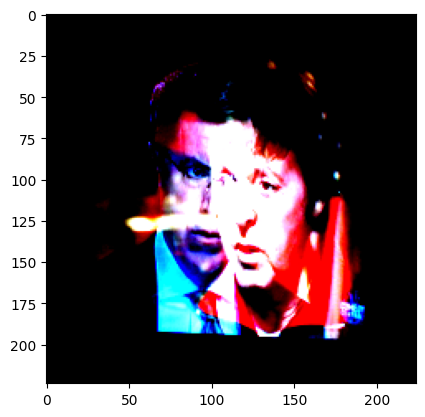

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from src.dataset.coco import get_coco
import src.dataset.DatasetReader as DatasetReader
import matplotlib.pyplot as plt
import src.dataset.utils as utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

dataset = DatasetReader.COCODataset(annotation_file='../data/annotations/annotations/instances_val2017.json',
    image_dir= '../data/val2017/val2017',
    target_classes=set([s.lower() for s in utils.GLOBAL_CLASSES]),
    transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

plt.imshow(dataset[50][0].permute(1, 2, 0).numpy())

model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 90)  
model = model.to(device)

for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(dataloader):

            #print(type(images))
            #print(type(labels))
            #print(labels)

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            # print(type(outputs))
            # print(outputs.shape)

            # print(type(labels))
            # print(labels.shape)
            # print(labels)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.4f}")

train_model(model, dataloader, criterion, optimizer)